<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
#from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('capstone_user_identification' )

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    files = glob(os.path.join(path_to_csv_files,'*.csv'))
    site_freq = pickle.load(file=open(site_freq_path, 'rb'))
    n_features = 2*session_length+4
    res = np.empty([0,n_features])
    
    for user, x in tqdm_notebook(enumerate(files)):
        data = pd.read_csv(x)
        val = data.site.values
        times = data.timestamp.apply(pd.to_datetime)
        n_session = int(np.ceil(float(len(val))/(window_size)))
        
        temp = np.zeros((n_session, n_features))
        i = 0
        while i<len(val):
            for j in range(i,min(i+session_length,len(val))):
                temp[int(i/window_size)][j-i] = site_freq[val[j]][0]
                if j< min(i+session_length-1,len(val)-1):
                    temp[int(i/window_size)][j-i+session_length] = (times[j+1]-times[j]).seconds#time_diff
            time_ses = times[i:min(i+session_length,len(times))]
            min_time_ses = min(time_ses)
            temp[int(i/window_size)][2*session_length-1] = (max(time_ses)-min_time_ses).seconds#session_timespan
           
            un = np.unique(temp[int(i/window_size),0:session_length])
            temp[int(i/window_size)][2*session_length] = len(un)-(1 if 0 in un else 0)#unique_sites
            temp[int(i/window_size)][2*session_length+1] =min_time_ses.hour#start_hour
            temp[int(i/window_size)][2*session_length+2] =min_time_ses.dayofweek#day_of_week
            temp[int(i/window_size)][2*session_length+3] = int(x[-8:][:4])#target
            i += window_size

        res = np.append(res,temp,axis=0)
        
        
    col = ['site' + str(i) for i in range(1,session_length+1)] + ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
    df = pd.DataFrame(res,columns=col)
    return df.loc[:,feature_names]

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

A Jupyter Widget

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [5]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 40.9 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5.0,8.0,4.0,31.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10.0,8.0,4.0,31.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7.0,8.0,4.0,31.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6.0,8.0,4.0,31.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9.0,8.0,4.0,31.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 7min 52s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]
new_features_150users = train_data_150users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [47]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [48]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0xbf1aac8>, <matplotlib.text.Text at 0xcd2c4a8>]

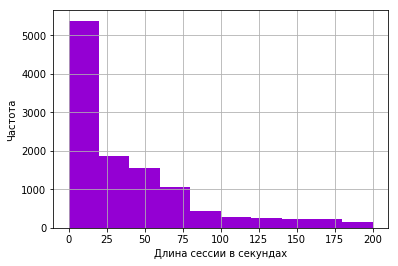

In [13]:
train_data_10users['session_timespan'][train_data_10users.session_timespan<=200].hist(color = 'darkviolet').set(xlabel=u'Длина сессии в секундах', ylabel=u'Частота')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0xc215208>, <matplotlib.text.Text at 0xc4c89b0>]

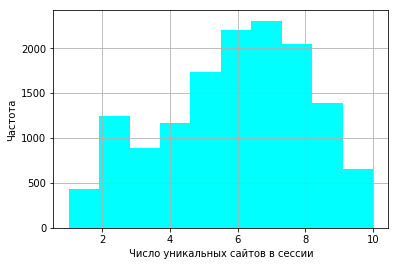

In [14]:
train_data_10users['#unique_sites'].hist(color = 'aqua').set(xlabel=u'Число уникальных сайтов в сессии', ylabel=u'Частота')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

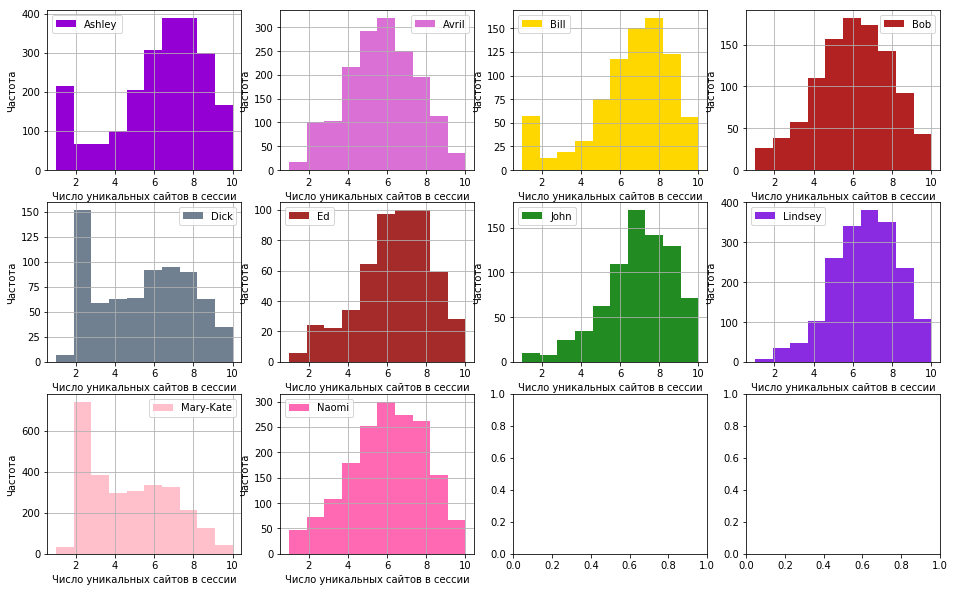

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['#unique_sites'].hist(ax = axes[idx/4][idx%4],color = color_dic[user]).set(xlabel=u'Число уникальных сайтов в сессии', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])
   


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0xd091ef0>, <matplotlib.text.Text at 0xeb231d0>]

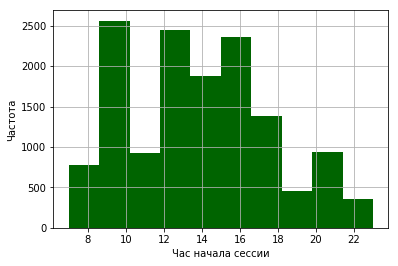

In [16]:
train_data_10users['start_hour'].hist(color = 'darkgreen').set(xlabel=u'Час начала сессии', ylabel=u'Частота')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

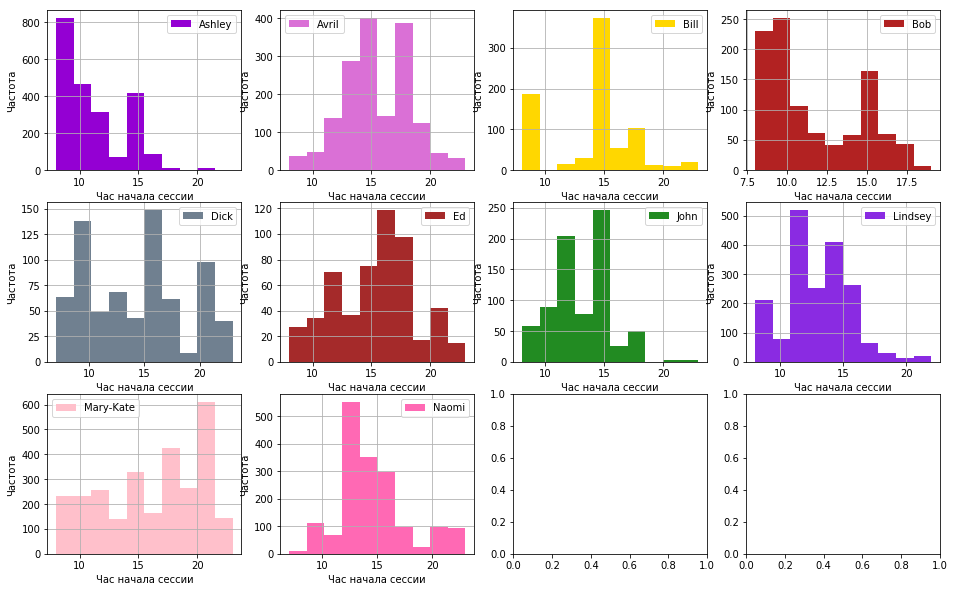

In [87]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
   
    sub_df['start_hour'].hist(ax = axes[idx/4][idx%4],color = color_dic[user]).set(xlabel=u'Час начала сессии', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

[<matplotlib.text.Text at 0x11e317b8>, <matplotlib.text.Text at 0xec4f668>]

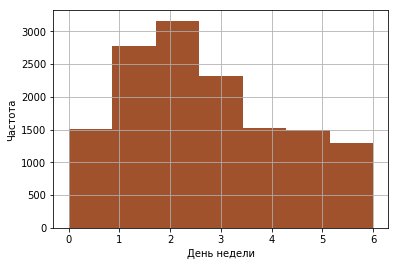

In [18]:
train_data_10users['day_of_week'].hist(color = 'sienna', bins = 7).set(xlabel=u'День недели', ylabel=u'Частота')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

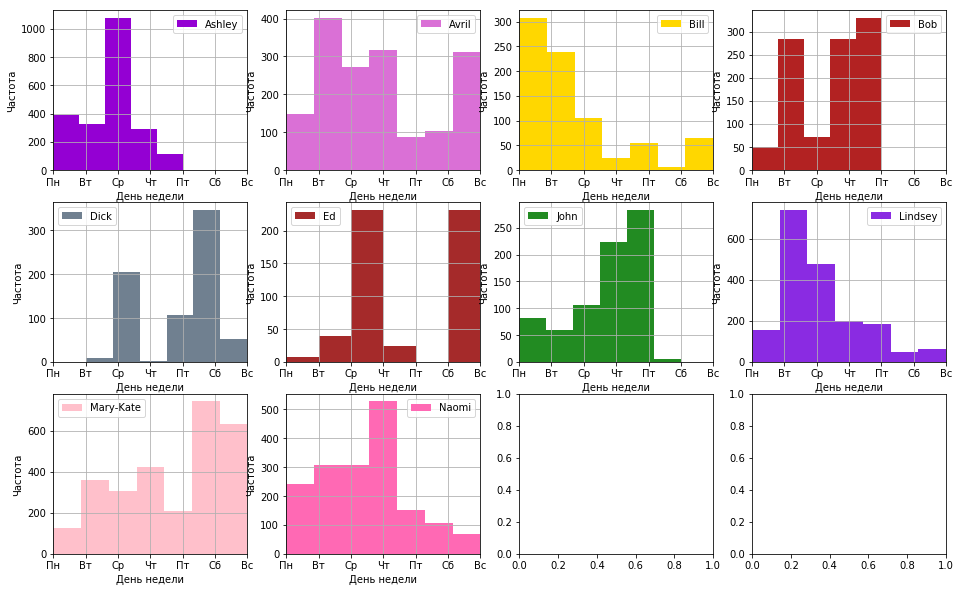

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['day_of_week'].hist(ax = axes[idx/4][idx%4],color = color_dic[user],bins = len(sub_df['day_of_week'].unique())).set(xlabel=u'День недели', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])
    axes[idx/4][idx%4].set_xlim(0,6)
    axes[idx/4][idx%4].set_xticklabels( [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По числу уникальных сайтов в сессии можно сделать вывод, что большинство пользователей чаще всего посещают 6-8 различных сайтов за сессию. Однако у некоторых пользователей (Ashley, Bill, Dick, Mary-Kate) также явно выделяется пик в районе 1-2, т.е. достаточно часто эти пользователи за сессию посещают всего один или два сайта.

По времени начала сессии можно сказать:
- Ashley начинает сессии в основном в утренние часы и в районе 15 часов, вечером практически не начинает;
- Avril начинает сессии в основном в дневное время, чаще всего в районе 14-15 и 18 часов.
- Bill чаще всего начинает сесии в 15 часов днем и в 8-9 часов утра
- Bob начинает сессии в основном в утренние часы, а также в районе 15 часов
- Dick чаще начинает сессии в 9-10 утром, 15-16 днем и 20-12 вечером.
- Ed в основном начинает сессии в дневное время, пики приходятся на 11-12 часов и 15-17 часов, вечером сессии реже, чаще всего начинаются в районе 21 часа
- John начинает сессии в дневное время, чаще всего в районе 11-12 и 15 часов, в вечернее время сессий практически нет
- Lindsey начинает сессии в основном в дневное время, чаще всего около 12, но довольно часто и утром, в 8-9, вечером значительно реже.
- Mary-Kate начинает сессии в течение всего дня, однако чаще всего в районе 15, 18 и 21 часов.
- Naomi в основном начинает сессии в дневное время, чаще всего в районе 13 часов, утром и вечером реже
 
По дням недели:
- Ashley начинает сессии только по будням, чаще всего по средам
- Avril начинает сессии в течение всей недели, чаще всего со вторника до четверга, а также в воскресенье
- Bill чаще начинает сессии в начале недели, чем в конце
- Bob начинает сессии только по будням, чаще во вторник, четверг и пятницу
- Dick чаще всего начинает сессии в среду и субботу, а в понедельник, вторник и четверг практически не начинает
- Ed в основном начинает сессии в среду и воскресенье
- John в основном начинает сессии по будням, чаще к концу недели, по выходным сессий практически нет
- Lindsey начинает сессии чаще всего по вторникам и средам, в выходные значительно реже, чем в будни
- Mary-Kate начинает сессии в течение всей недели,но чаще всего в выходные 
- Naomi чаще всего начинает сессии в четверг, сессии в начале недели чаще, чем в конце

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [7]:
site_freq_10 = pickle.load(file=open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb'))  

In [21]:
sorted_sites = sorted(zip([x[1] for x in site_freq_10.values()],site_freq_10.keys()),reverse=True)[:10]

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_freqs = [x[0] for x in sorted_sites]
top10_sites = [x[1] for x in sorted_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

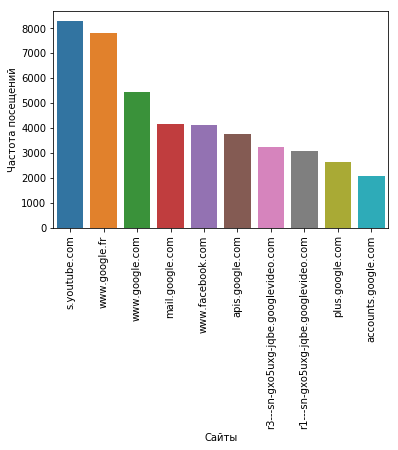

In [23]:
sns.barplot (x = top10_sites,y = top10_freqs)
plt.xticks(rotation = 90)
plt.xlabel(u'Сайты')
plt.ylabel(u'Частота посещений')

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [40]:
def feature_engineering(path_to_csv_files, features, session_length=10, window_size = 10):
    files = glob(os.path.join(path_to_csv_files,'*.csv'))
    n_features = 5
    res = np.empty([0,n_features])
    for user, x in tqdm_notebook(enumerate(files)):
        data = pd.read_csv(x)
        val = data.site.values
        times = data.timestamp.apply(pd.to_datetime)
        n_session = int(np.ceil(float(len(val))/(window_size)))
        
        temp = np.zeros((n_session, n_features))
        i = 0
        while i<len(val):
   
            temp[int(i/window_size)][0] = times[i].day
            temp[int(i/window_size)][1] = times[i].month
            temp[int(i/window_size)][2] = times[i].year
            temp[int(i/window_size)][3] = (0 if times[i].dayofweek<5 else 1)
            
            
            temp[int(i/window_size)][4] = int(x[-8:][:4])#target
            i += window_size

        res = np.append(res,temp,axis=0)
    col = ['day', 'month', 'year', 'is_weekend', 'target']
    df = pd.DataFrame(res,columns=col)
    return df.loc[:,features]

In [41]:
feature_engineering(os.path.join(PATH_TO_DATA, '3users'), ['day', 'month', 'year', 'is_weekend', 'target'])

A Jupyter Widget

,day,month,year,is_weekend,target
0,15.0,11.0,2013.0,0.0,1.0
1,15.0,11.0,2013.0,0.0,1.0
2,15.0,11.0,2013.0,0.0,2.0
3,15.0,11.0,2013.0,0.0,3.0
4,15.0,11.0,2013.0,0.0,3.0


In [42]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), ['day', 'month', 'year', 'is_weekend', 'target'])

A Jupyter Widget

In [43]:
new_features_150users = feature_engineering (os.path.join(PATH_TO_DATA, '150users'), ['day', 'month', 'year', 'is_weekend', 'target'])

A Jupyter Widget

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

[<matplotlib.text.Text at 0xc988588>, <matplotlib.text.Text at 0xca1c0b8>]

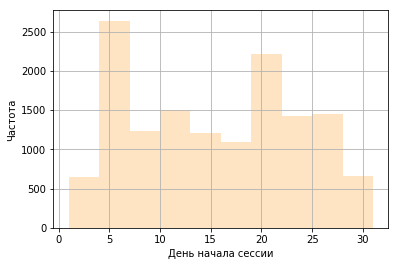

In [45]:
new_features_10users['day'].hist(color = 'bisque').set(xlabel=u'День начала сессии', ylabel=u'Частота')

In [50]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

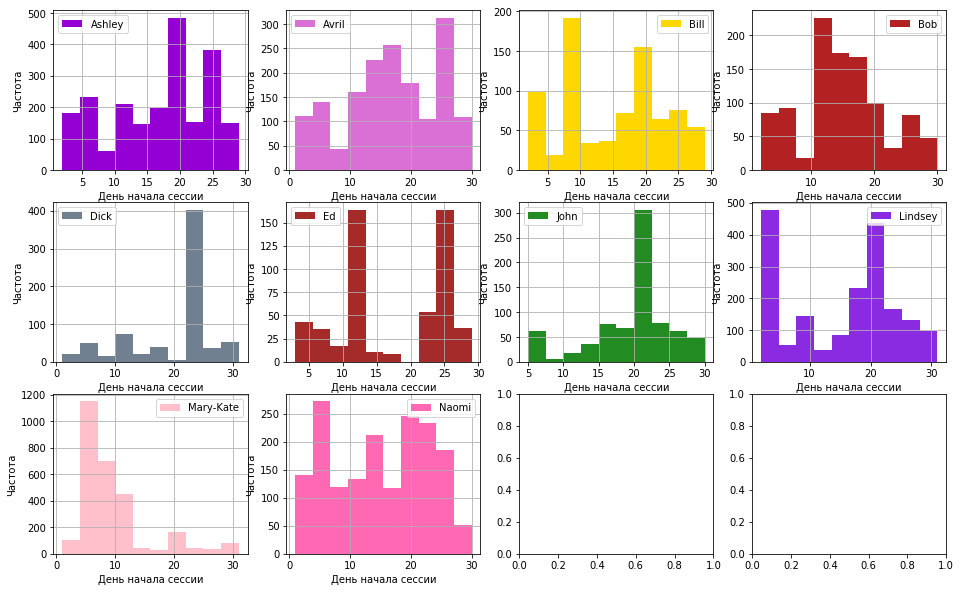

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
   
    sub_df['day'].hist(ax = axes[idx/4][idx%4],color = color_dic[user]).set(xlabel=u'День начала сессии', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])

[<matplotlib.text.Text at 0x11784c50>, <matplotlib.text.Text at 0x117434e0>]

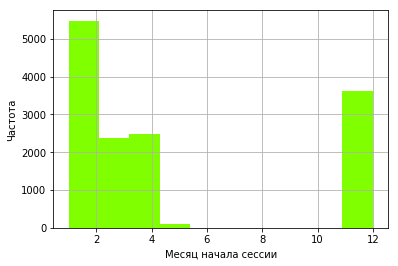

In [52]:
new_features_10users['month'].hist(color = 'chartreuse').set(xlabel=u'Месяц начала сессии', ylabel=u'Частота')

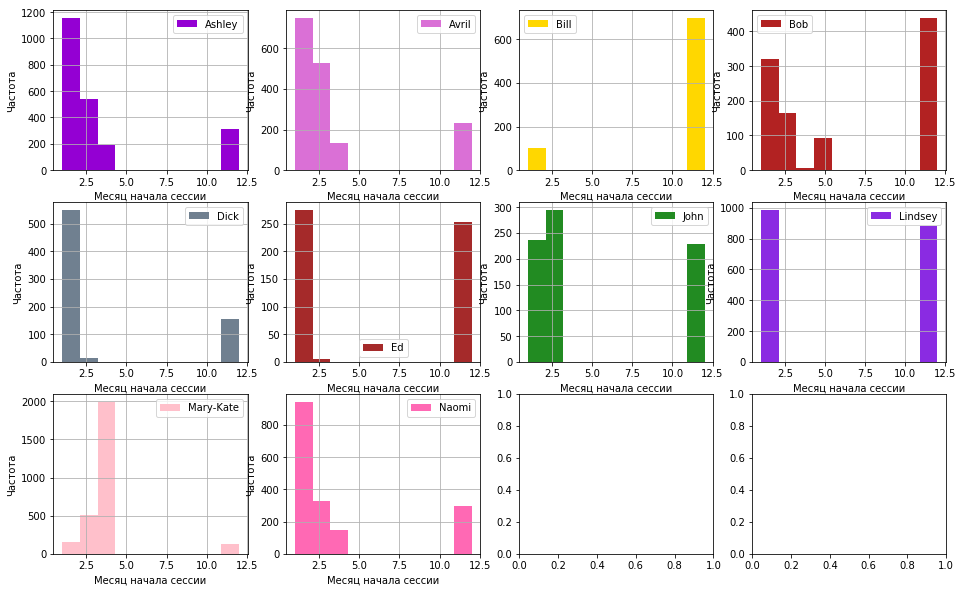

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
   
    sub_df['month'].hist(ax = axes[idx/4][idx%4],color = color_dic[user]).set(xlabel=u'Месяц начала сессии', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])
    

[<matplotlib.text.Text at 0x11cfb048>, <matplotlib.text.Text at 0xe8e2358>]

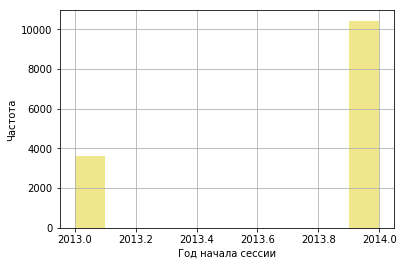

In [62]:
new_features_10users['year'].hist(color = 'khaki').set(xlabel=u'Год начала сессии', ylabel=u'Частота')

[<matplotlib.text.Text at 0xef7a0b8>, <matplotlib.text.Text at 0x123e54a8>]

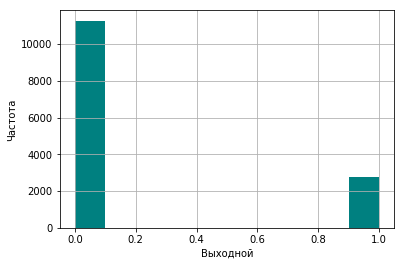

In [64]:
new_features_10users['is_weekend'].hist(color = 'teal').set(xlabel=u'Выходной', ylabel=u'Частота')

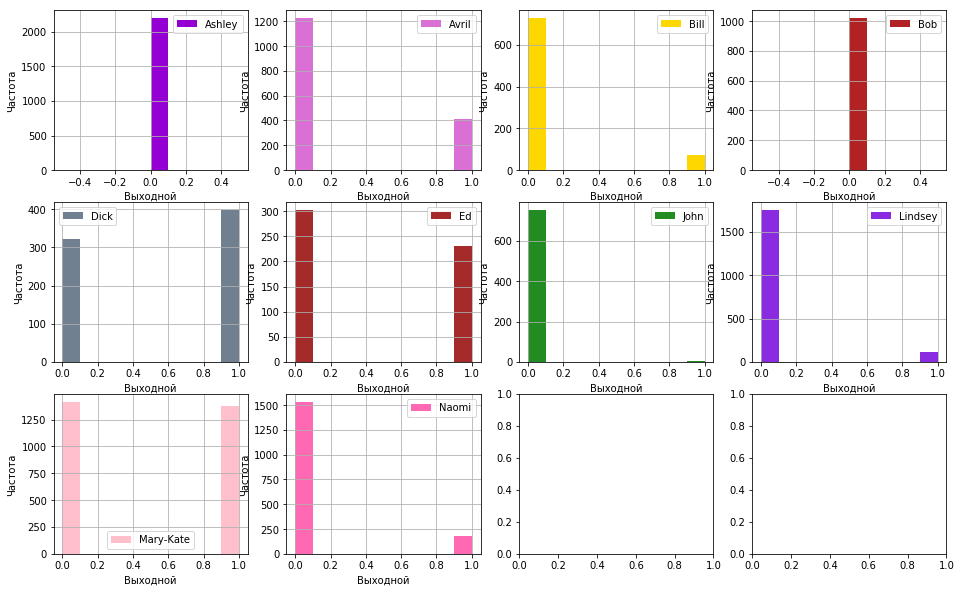

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
   
    sub_df['is_weekend'].hist(ax = axes[idx/4][idx%4],color = color_dic[user]).set(xlabel=u'Выходной', ylabel=u'Частота')
    axes[idx/4][idx%4].legend([user])

In [73]:

train_data_10users[['day','month','is_weekend']] = new_features_10users[['day','month','is_weekend']]

train_data_150users[['day','month','is_weekend']] = new_features_150users[['day','month','is_weekend']]



**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [74]:
selected_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week','day','month','is_weekend', 'target']]
selected_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week','day','month','is_weekend', 'target']]

In [75]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 